In [33]:
from qiskit.compiler import transpile, schedule, assemble
from qiskit.circuit.library import RZXGate
import pickle
from qiskit import execute, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ
from qiskit.transpiler.passes.scheduling.calibration_creators import RZXCalibrationBuilder

In [2]:
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter, TomographyFitter
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info.operators.channel import Choi, Kraus, PTM
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate


In [3]:
from qiskit.providers.aer.noise.errors.errorutils import standard_gate_unitary
from qiskit.quantum_info.operators.measures import process_fidelity
from qiskit.quantum_info import Choi, Kraus, Operator
import qiskit.quantum_info as qi

# Backend Set-up

In [4]:
provider = IBMQ.load_account()

In [5]:
#provider = IBMQ.save_account('bc105c39d9a7126c0d0676289f99065f525c6d739c807848153f6d1dd19907d6d433577b8c34a1959654f82f12418f09d115a1b8eb3db8dab6fabe1192da1643')

In [6]:
provider_pulse = IBMQ.get_provider(hub='ibm-q-startup', group='phasecraft-ltd', project='pulse-level-cont')

In [7]:
# casablanca or bogota for our pulse experiments
device_name = 'ibmq_bogota'
backend = provider_pulse.get_backend(device_name)

# from backend
config = backend.configuration()
props = backend.properties()
defaults = backend.defaults()

assert config.open_pulse, "Backend doesn't support Pulse"

# default calibrations, basis gates and instruction map
basis_gates = config.basis_gates
dt = config.dt
inst_map = defaults.instruction_schedule_map
RZX_cals = RZXCalibrationBuilder(backend)

In [8]:
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds


Sampling time: 0.2222222222222222 ns


In [9]:
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q1: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q2: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q3: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q4: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (2, 1): {'cx'}
  (2, 3): {'cx'}
  (3, 2): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>


# RZ Pulse Tomography

## Choose specific qubits and angles 

In [10]:
# pick qubits and angles
# will define custom gates for just this pair of qubits and these angles
# then we link the CR scaled RZ schedules to our custom gates

qubits = (2, 3)

number_of_angles = 5
angles = np.round(
                  np.linspace(0.1, np.pi, number_of_angles),
                  2)

In [11]:
rz_schedules = {str(angle): RZX_cals.get_calibration([angle] , qubits) for angle in angles}

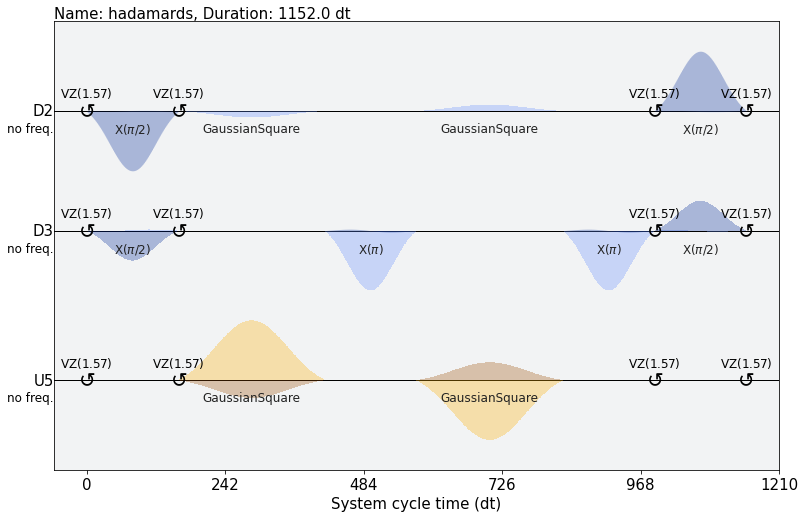

In [12]:
# the shortest duration pulse schedule, gaussian square pulses are the CR pulse that get scales with the angle
rz_schedules['0.1'].draw()

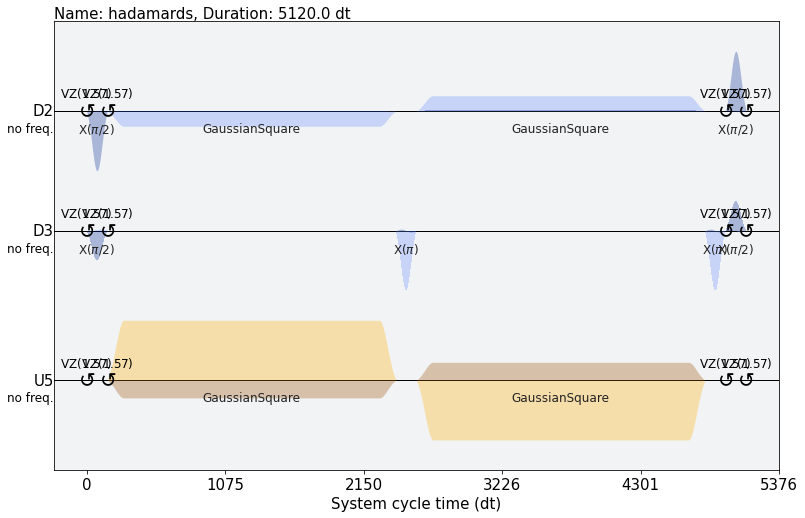

In [13]:
# contrast with longest pulse schedule
rz_schedules['3.14'].draw()

In [14]:
rz_schedule_durations = [rz_schedules[f'{angle}'].duration/(dt*1e9) for angle in angles]

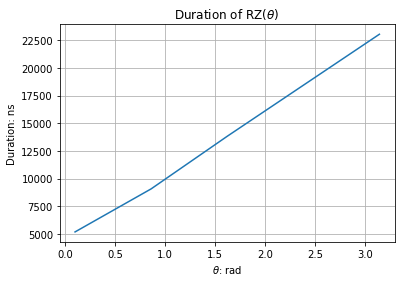

In [15]:
plt.plot(angles, rz_schedule_durations)
plt.xlabel(r'$\theta$: rad')
plt.ylabel('Duration: ns')
plt.title(r'Duration of RZ($\theta$)')
plt.grid()
plt.show()

## Adding custom gate names and linking them to the scaled pulse schedules

In [17]:
for angle in angles:
    gate_name = f'rzx_{angle}'
    basis_gates += [gate_name]
    inst_map.add(gate_name, qubits, rz_schedules[str(angle)])

In [18]:
print(f'Updated instruction schedule map: \n\n {inst_map}')

Updated instruction schedule map: 

 <InstructionScheduleMap(1Q instructions:
  q0: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q1: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q2: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q3: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
  q4: {'u1', 'rz', 'u2', 'u3', 'measure', 'x', 'sx', 'id'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (2, 1): {'cx'}
  (2, 3): {'rzx_0.1', 'cx', 'rzx_1.62', 'rzx_0.86', 'rzx_3.14', 'rzx_2.38'}
  (3, 2): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>


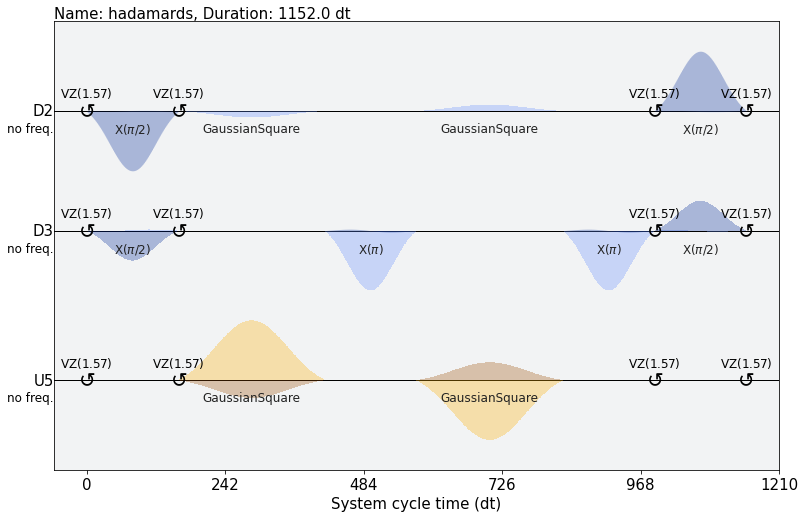

In [19]:
# checking that the correct shedule is linked to the correct gate name
inst_map.get('rzx_0.1', qubits).draw()

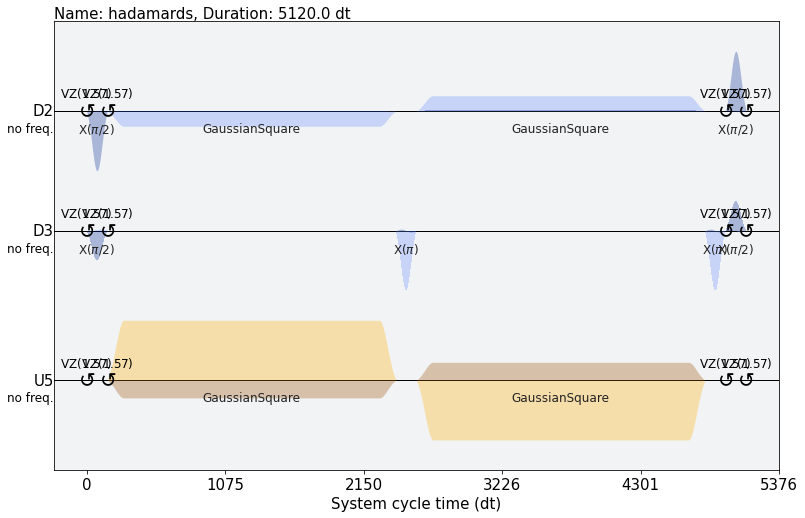

In [20]:
inst_map.get('rzx_3.14', qubits).draw()

## Setting up the tomography circuits

In [21]:
# our custom gates that we need to make tomography circuits for
gates = {str(angle): Gate(f'rzx_{angle}', 2, []) for angle in angles}

In [22]:
label = '21.May'

In [44]:
qpt_experiments = {}

for angle in angles:
    
    qregs = QuantumRegister(config.n_qubits)
    
    gate = gates[str(angle)]
    circuit = QuantumCircuit(qregs)
    circuit.compose(gate, [qregs[qubits[0]], qregs[qubits[1]]], inplace=True) 
    
    qpt_circuits = process_tomography_circuits(circuit, [qregs[qubits[0]], qregs[qubits[1]]]) 
    qpt_circuits_transpiled = transpile(qpt_circuits, backend, basis_gates) # withou
    qpt_schedules = schedule(qpt_circuits_transpiled, backend, inst_map)
    
    qpt_experiments[str(angle)] = {'pre_transpiled_circuits': qpt_circuits,
                                   'transpiled_circuits': qpt_circuits_transpiled,
                                   'qpt_schedules': qpt_schedules}

In [45]:
#doesn't know how to do hadamard on this device without transpiling etc
qpt_experiments['3.14']['pre_transpiled_circuits'][0].draw()

░               ░            
q27_0: ─░───────────────░────────────
        ░               ░            
q27_1: ─░───────────────░────────────
        ░ ┌───────────┐ ░ ┌───┐┌─┐   
q27_2: ─░─┤0          ├─░─┤ H ├┤M├───
        ░ │  rzx_3.14 │ ░ ├───┤└╥┘┌─┐
q27_3: ─░─┤1          ├─░─┤ H ├─╫─┤M├
        ░ └───────────┘ ░ └───┘ ║ └╥┘
q27_4: ─░───────────────░───────╫──╫─
        ░               ░       ║  ║ 
c24: 2/═════════════════════════╩══╩═
                                0  1

In [46]:
qpt_experiments['3.14']['transpiled_circuits'][0].draw()

global phase: π/2
            ░               ░                                   
q27_0 -> 0 ─░───────────────░───────────────────────────────────
            ░               ░                                   
q27_1 -> 1 ─░───────────────░───────────────────────────────────
            ░ ┌───────────┐ ░ ┌─────────┐┌────┐┌─────────┐┌─┐   
q27_2 -> 2 ─░─┤0          ├─░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├┤M├───
            ░ │  rzx_3.14 │ ░ ├─────────┤├────┤├─────────┤└╥┘┌─┐
q27_3 -> 3 ─░─┤1          ├─░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─╫─┤M├
            ░ └───────────┘ ░ └─────────┘└────┘└─────────┘ ║ └╥┘
q27_4 -> 4 ─░───────────────░──────────────────────────────╫──╫─
            ░               ░                              ║  ║ 
    c24: 2/════════════════════════════════════════════════╩══╩═
                                                           0  1

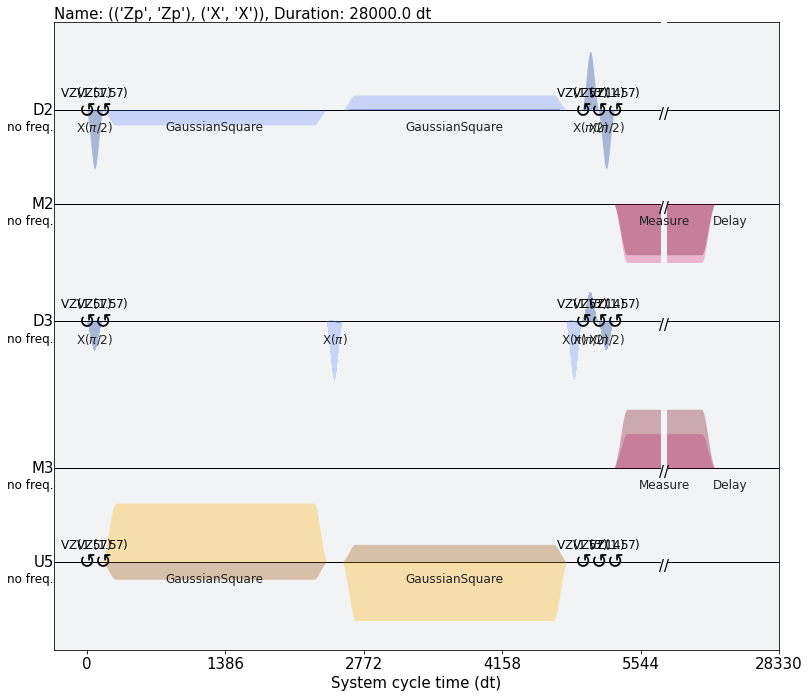

In [47]:
qpt_experiments['3.14']['qpt_schedules'][0].draw()

In [27]:
results = {}

for angle in angles:
    qpt_sched = qpt_experiments[str(angle)]['qpt_schedules']
    job = execute(qpt_sched, backend=backend, shots=512)
    result = job.result()
    results[f'{angle}'] = result

/home/laura/.local/lib/python3.9/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [29]:
with open(f'results/{device_name}/{label}.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
fidelities = {}
q2 = QuantumRegister(2)

for angle in angles:
   
    qpt_circuits = qpt_experiments[str(angle)]['transpiled_circuits']
    res = results[str(angle)]
    
    process_data = ProcessTomographyFitter(res, qpt_circuits,meas_basis='Pauli', prep_basis='Pauli')
    choi_fit = process_data.fit( )#method='cvx', standard_weights=True,kwargs={ "trace_preserving":True, "PSD": True})
    choi_fit = choi_fit.data
   
    ideal_circ = QuantumCircuit(q2)
    ideal_circ.rzx(angle,q2[0],q2[1])
    ideal=qi.Operator(ideal_circ)
    fid = qi.average_gate_fidelity(channel=Choi(choi_fit),target=Operator(ideal.data))
    fidelities[str(angle)] = fid

Input channel is not CP. Choi-matrix has negative eigenvalues: [-8.66981379e-05 -6.99124138e-05 -5.83070450e-05 -4.17949758e-05
 -1.79141012e-05 -7.48329038e-06]
Input channel is not CP. Choi-matrix has negative eigenvalues: [-7.65557847e-05 -5.97193664e-05 -4.43678387e-05 -1.82164580e-05
 -4.50409540e-06]
Input channel is not CP. Choi-matrix has negative eigenvalues: [-6.91477689e-05 -4.33476986e-05 -2.47942387e-05 -1.07176270e-05
 -3.55566393e-06]
Input channel is not CP. Choi-matrix has negative eigenvalues: [-8.33992007e-05 -7.10728585e-05 -4.69270182e-05 -1.44097316e-05
 -6.59308161e-06]
Input channel is not CP. Choi-matrix has negative eigenvalues: [-6.65580102e-05 -2.96852915e-05 -4.56629245e-06]


In [32]:
fidelities

{'0.1': 0.9199263044601853,
 '0.86': 0.9229109119207273,
 '1.62': 0.9103216801945759,
 '2.38': 0.8878329271511258,
 '3.14': 0.8945818389744465}